In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from concurrent.futures import ThreadPoolExecutor

import rasterio as rio
from rasterio.crs import CRS

import cv2
from affine import Affine
import numpy as np
import glob

from tqdm.notebook import tqdm

Image.MAX_IMAGE_PIXELS = 933120000

In [2]:
# REFERENCE IMAGE FROM QGIS
template = Image.open(r"data\GIS\Harris_full_roadsclipped_dark_full.tiff")
# template = Image.open(r"data\GIS\template_cropped.png")

# TILE INDEX TO TEST ON
# test_index = Image.open(r"data\000_WorkingFiles\HarrisIndexes\48201CIND0_0992.tif")
test_index = Image.open(r"data\000_WorkingFiles\HarrisIndexes\48201CIND0_1196.tif")

def bomb_sides(image, n, replacement_value):
    result = np.copy(image)
    rows, cols = image.shape

    # Replace values in the left and right columns
    result[:, :n] = replacement_value
    result[:, -n:] = replacement_value

    # Replace values in the top and bottom rows
    result[:n, :] = replacement_value
    result[-n:, :] = replacement_value

    return result

def preprocess_image_good(image):
    image = np.asarray(image) 
    image = image.astype(np.uint8)
    image = 255 * ((image - np.nanpercentile(image, 10)) / (np.nanpercentile(image, 90) - np.nanpercentile(image, 10)))
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 150, 0, 255).astype(np.uint8)
    image = cv2.GaussianBlur(image, (15, 15), 0)
    image = 255 - image
    image = bomb_sides(image, 200, 0)
    return image

def preprocess_image_good(image):
    image = np.asarray(image) * 255
    image = image.astype(np.uint8)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    image = cv2.dilate(image, np.ones((3,3), np.uint8), iterations=1)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 50, 0, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=5)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = 255 - image
    return image

def preprocess_image_working(image):
    image = np.asarray(image) * 255
    image = bomb_sides(image, 255, 500)
    image = image.astype(np.uint8)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=10)
    image = cv2.GaussianBlur(image, (15, 15), 0)
    image = 255 - image
    return image

def preprocess_template(template, image):
    template = np.asarray(template).astype(np.uint8)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    template = template.astype(np.uint8)
    template = 255 - template
    scale = image.shape[1] / template.shape[1]
    template = cv2.resize(template, None, fx=scale, fy=scale)
    return template


test_preprocess = preprocess_image_good(test_index)
template = preprocess_template(template, test_preprocess)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\000_WorkingFiles\\HarrisIndexes\\48201CIND0_1196.tif'

In [5]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=7, padding=3)
        self.conv5 = nn.Conv2d(32, out_channels, kernel_size=7, padding=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        return x

In [6]:
model = torch.load('preprocess.pth').to('cpu')

In [7]:
# Specify the directory path containing the images
directory = r'data\000_WorkingFiles\HarrisIndexes'

# Specify the list of file extensions of the images (e.g., ['.jpg', '.png'])
file_extensions = ['.jpg', '.png', '.tif']

# Get the list of image file paths
image_paths = []
for extension in file_extensions:
    image_paths.extend(glob.glob(os.path.join(directory, '*' + extension)))

In [ ]:
   transform = transforms.Compose([
    transforms.PILToTensor()
])

prepped_images = []

# Loop through the image paths
for image_path in image_paths:
    # Process each image path
    print("Processing image:", image_path)
    image = Image.open(image_path)
    # image = preprocess_image_good(image)
    image = transform(image).float().to("cpu")
    image = model(image)
    image = image.detach().cpu().numpy().squeeze()
    
    # bott, top = np.percentile(image, [10, 90])
    
    # image = 255 * (image - bott) / (top - bott)
    image = image.astype(np.uint8)
    
    prepped_images.append(image_path[:-4] + f"_prep.tif")
    cv2.imwrite(image_path[:-4] + f"_prep.tif", image)

Processing image: data\000_WorkingFiles\HarrisIndexes\480287IND0_0281.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\480287IND0_0288.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\480287IND0_0382.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\480287IND0_0985.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\480296IND0_0982.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\480296IND0_0985.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\480296IND0_0987.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\480296IND0_1279.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\48201CIND0_0990.jpg
Processing image: data\000_WorkingFiles\HarrisIndexes\48201CIND0_0992.tif


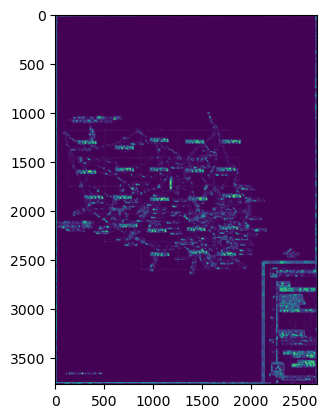

In [33]:
for image_path in prepped_images:
    print("Processing image:", image_path)
    image = Image.open(image_path)
    
    bott, top = np.percentile(image, [1, 99])
    image = 255 * (image - bott) / (top - bott)
    image = image.astype(np.uint8)
    

In [5]:
class ReturnValues:
    def __init__(self, _result, _mask, _rotated_template, _scale, _angle):
        self.result = _result
        self.mask = _mask
        self.rotated_template = _rotated_template
        self.scale = _scale
        self.angle = _angle

def wrapPattern(scale):
    return patternMatch(test_preprocess, template, scale, 0)

def patternMatch(test_preprocess, template, scale, angle, method=cv2.TM_SQDIFF):
    # Resize the template based on the current scale
    scaled_template = cv2.resize(template, None, fx=scale, fy=scale)
    
    # Rotate the template based on the current angle
    rotation_matrix = cv2.getRotationMatrix2D((scaled_template.shape[1] / 2, scaled_template.shape[0] / 2), angle, 1.0)
    rotated_template = cv2.warpAffine(scaled_template, rotation_matrix, (scaled_template.shape[1], scaled_template.shape[0]))
        
    mask = np.where(rotated_template == 0, 0, 255).astype(np.uint8)
    # Perform template matching
    result = cv2.matchTemplate(test_preprocess, rotated_template, method, mask=mask)
    return ReturnValues(result, mask,rotated_template, scale, angle)

def postprocess_results(result_list, scales, opt_max):
    elem_list = [x.flatten() for x in result_list]
    elem_list = np.hstack(elem_list)

    if opt_max:
        thresh = np.percentile(elem_list, 99.9)
        loc_list = [x > thresh for x in result_list]
    else:
        thresh = np.percentile(elem_list, 0.1)
        loc_list = [x < thresh for x in result_list]

    votes = np.array([np.count_nonzero(x) for x in loc_list])
    rescale_factor = np.sum(votes * scales) / np.sum(votes)

    x_list = np.hstack([np.where(x)[0] for x in loc_list])
    y_list = np.hstack([np.where(x)[1] for x in loc_list])

    x = int(np.median(x_list))
    y = int(np.median(y_list))

    br = (int(y + template.shape[1] * rescale_factor), int(x + template.shape[0] * rescale_factor))
    
    return x, y, br, rescale_factor

In [6]:
def wrapSearch(initial_guess, perturbance, retall=True):
    scales = np.arange(initial_guess-perturbance, initial_guess+perturbance+1e-5, perturbance/2)

    # Initialize a list to store the matches
    all_matches = []

    # Initialize variables to store the best match
    best_match_scale = 1.0
    best_match_angle = 0.0

    opt_max = False

    if opt_max:
        best_match_value = -1 * np.inf
    else:
        best_match_value = np.inf

    result_list = list()
    best_loc_list = list()
    rect_corner_list = list()

    with ThreadPoolExecutor(max_workers=4) as executor:
        for retvalue in tqdm(executor.map(wrapPattern, scales), total=len(scales)):

            mask = retvalue.mask
            result = retvalue.result
            rotated_template = retvalue.rotated_template
            scale = retvalue.scale
            angle = retvalue.angle
            if not opt_max:
                result = np.sqrt(result / np.count_nonzero(mask))

            result_list.append(result)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            if opt_max:
                best_val = max_val
                best_loc = max_loc
                bottom_right = (best_loc[0] + int(rotated_template.shape[1]), best_loc[1] + int(rotated_template.shape[0]))

                best_loc_list.append(best_loc)
                rect_corner_list.append(bottom_right)

            else:
                best_val = min_val
                best_loc = min_loc
                bottom_right = (best_loc[0] + int(rotated_template.shape[1]), best_loc[1] + int(rotated_template.shape[0]))
                best_loc_list.append(best_loc)
                rect_corner_list.append(bottom_right)            

            print(scale, angle, best_val)
        
        postprocess = postprocess_results(result_list, scales, opt_max)
    
    if not retall:
        return postprocess[3]
    return postprocess

In [7]:
curr_guess = 0.8
perturbations = [0.1, 0.05, 0.025, 0.0125]

for i, pert in enumerate(perturbations):
    x, y, br, rescale_factor = wrapSearch(curr_guess, pert)
    curr_guess = rescale_factor

  0%|          | 0/5 [00:00<?, ?it/s]

0.7000000000000001 0 126.77954746923128
0.7500000000000001 0 126.67089024479698
0.8000000000000002 0 126.82986017606385
0.8500000000000002 0 127.22911185778047
0.9000000000000002 0 127.50554058268173


  0%|          | 0/5 [00:00<?, ?it/s]

0.6776391335178535 0 126.70069295980923
0.7026391335178536 0 126.75655320093911
0.7276391335178536 0 126.76106875675096
0.7526391335178536 0 126.64815116979533
0.7776391335178536 0 126.64681618208884


  0%|          | 0/5 [00:00<?, ?it/s]

0.7004068297082152 0 126.77634495685584
0.7129068297082152 0 126.72778723971679
0.7254068297082151 0 126.73349566633671
0.7379068297082151 0 126.77865965379127
0.750406829708215 0 126.6666429882934


  0%|          | 0/5 [00:00<?, ?it/s]

0.7145415341321479 0 126.72254003435471
0.7207915341321479 0 126.69532757080341
0.7270415341321479 0 126.7537825527051
0.7332915341321479 0 126.76748312980311
0.7395415341321478 0 126.75832600739727


In [8]:
rescale_factor

0.7266438068594205

In [9]:
three_band = np.dstack([test_preprocess,test_preprocess,test_preprocess])
    
# _ = cv2.rectangle(three_band, best_match_loc, best_match_br, (0, 0, 255), 5)
_ = cv2.rectangle(three_band, (y, x), br, (0, 255, 0), 5)

In [10]:
cv2.imwrite('testout.png', three_band)

True